In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

y_train_cls = y_train.astype(np.int32)
y_test_cls = y_test.astype(np.int32) 

y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32) 

print(x_train.shape, x_train.dtype) 
print(y_train.shape, y_train.dtype) 
print(y_train_cls.shape, y_train_cls.dtype) 
print(x_test.shape, x_test.dtype)  
print(y_test.shape, y_test.dtype)  
print(y_test_cls.shape, y_test_cls.dtype)

(60000, 784) float32
(60000, 10) float32
(60000,) int32
(10000, 784) float32
(10000, 10) float32
(10000,) int32


In [2]:
lr = 3e-5 
epoch = int(1e2) 
batch_size = 100

layer_widths = [784, 600, 500, 400, 300, 200, 100, 50, 10]
    
import numpy as np; np.random.seed(0)
import tensorflow as tf; tf.reset_default_graph()

y = tf.placeholder(tf.float32, (None, 10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)

from keras import models
from keras import layers 
from keras import initializers 

init_w = initializers.VarianceScaling(seed=0)
init_b = initializers.Zeros()

model = models.Sequential()
for i, layer_width in enumerate(layer_widths[1:]):
    if i==0:
        model.add(layers.Dense(layer_width, 
                               kernel_initializer=init_w,
                               bias_initializer=init_b,
                               activation='relu',
                               input_shape=(784,)))
    elif i!=len(layer_widths[1:])-1:
        model.add(layers.Dense(layer_width, 
                               kernel_initializer=init_w,
                               bias_initializer=init_b,
                               activation='relu'))
    else:
        model.add(layers.Dense(layer_width, 
                               kernel_initializer=init_w,
                               bias_initializer=init_b,
                               activation=None))
        
x = model.input 
logits = model.output

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, 
                                                     logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), 
                     tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, 
                        name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), 
                          name='accuracy') # () float32

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [3]:
with tf.Session() as sess:
    
    sess.run(init)
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            if k==0:
                loss_temp = []
                accuracy_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            
            feed_dict = {x:x_batch, y:y_batch, y_cls:y_cls_batch}
            
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], 
                                                 feed_dict=feed_dict)
            
            loss_temp.append(loss_run) 
            accuracy_temp.append(accuracy_run)
        
        loss_avg = np.array(loss_temp).mean()
        accuracy_avg = np.array(accuracy_temp).mean()
        loss_trace.append(loss_avg)
        accuracy_trace.append(accuracy_avg)
        print(f'{i+1}/{epoch} loss {loss_avg}, accuracy {accuracy_avg} ')
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], 
                                             feed_dict=feed_dict)

1/100 loss 0.904920220375061, accuracy 0.7360000014305115 
2/100 loss 0.2907775938510895, accuracy 0.916783332824707 
3/100 loss 0.21894267201423645, accuracy 0.9365000128746033 
4/100 loss 0.17724640667438507, accuracy 0.9490333199501038 
5/100 loss 0.15053732693195343, accuracy 0.9564499855041504 
6/100 loss 0.13038991391658783, accuracy 0.962233304977417 
7/100 loss 0.11545262485742569, accuracy 0.966566801071167 
8/100 loss 0.10164006054401398, accuracy 0.970550000667572 
9/100 loss 0.09173668175935745, accuracy 0.9734500050544739 
10/100 loss 0.08320394903421402, accuracy 0.975600004196167 
11/100 loss 0.07461380213499069, accuracy 0.9783833622932434 
12/100 loss 0.06717102974653244, accuracy 0.9805499315261841 
13/100 loss 0.060183797031641006, accuracy 0.9828166961669922 
14/100 loss 0.05540793761610985, accuracy 0.9838166236877441 
15/100 loss 0.0494113527238369, accuracy 0.9859333038330078 
16/100 loss 0.04470514506101608, accuracy 0.987216591835022 
17/100 loss 0.039400566369

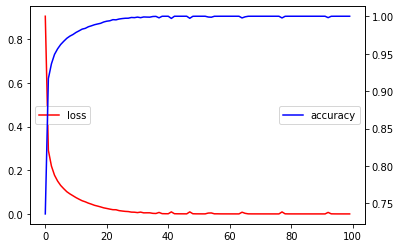

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(loss_trace, color='red', label='loss')
plt.legend(loc='center left')

ax2 = ax1.twinx() 
ax2.plot(accuracy_trace, color='blue', label='accuracy')
plt.legend(loc='center right')

plt.show()

In [5]:
print(f'Test Period Accuracy : {accuracy_run}')

Test Period Accuracy : 0.9807000160217285


In [6]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 971    0    2    0    0    1    2    1    2    1]
 [   0 1124    2    1    0    1    2    1    4    0]
 [   4    3 1013    3    1    0    2    4    2    0]
 [   0    0    3  992    0    5    0    4    4    2]
 [   2    0    5    0  965    0    2    0    1    7]
 [   3    0    0    9    2  866    3    1    6    2]
 [   4    3    0    0    5    6  939    0    1    0]
 [   2    4    7    0    1    0    0 1003    3    8]
 [   4    0    5    2    3    1    1    2  952    4]
 [   2    2    0    6    7    2    2    4    2  982]]


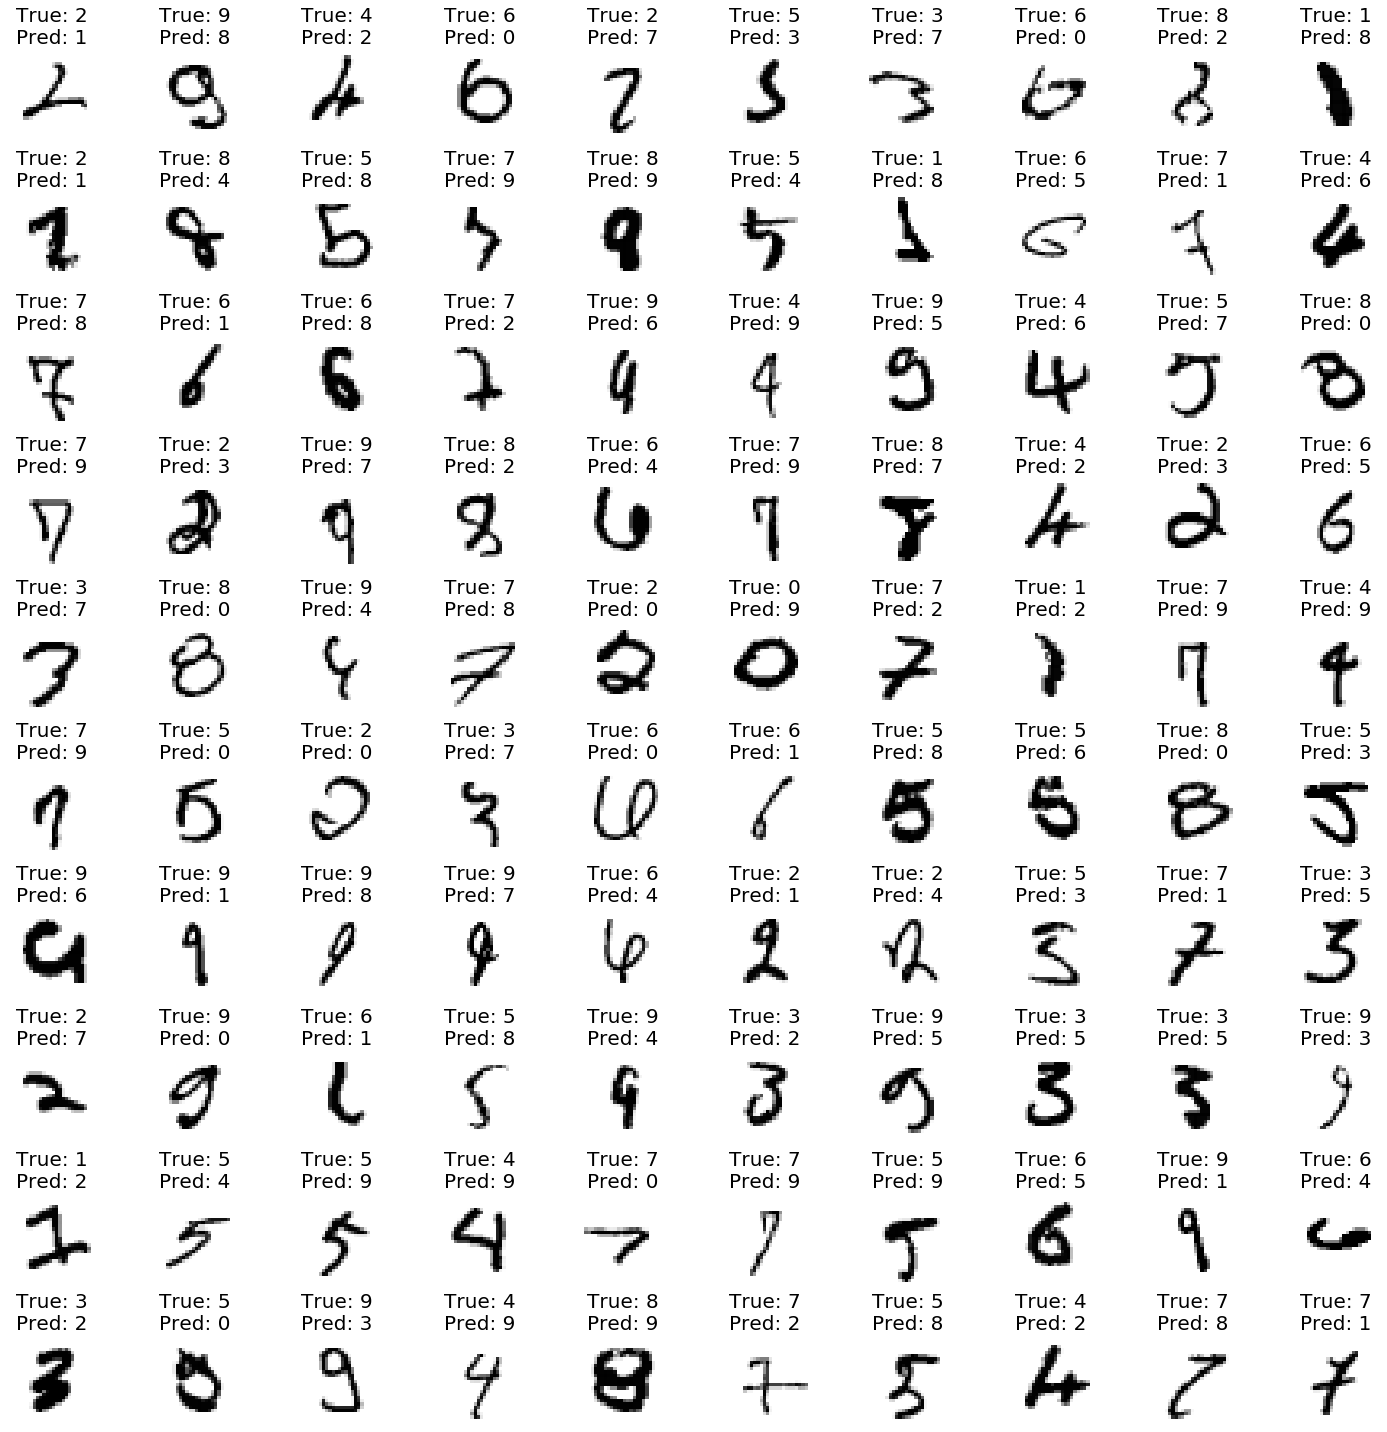

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))

idx = 0
for ax in axes.reshape((-1,)): # (2, 10) ---> (20,)
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap='binary')
            true_label = y_test_cls[idx]
            pred_label = y_test_cls_pred[idx]
            title = f'True: {true_label}\nPred: {pred_label}'
            ax.set_title(title, fontsize=20)
            ax.axis('off')
            idx += 1
            break
            
plt.tight_layout()

plt.show()